# Proper and improper mixtures

**Proper mixture:** A (mixed) state that is the average of several independent states, realisations, trajectories, etc.

Examples:
- an ensemble of independent spin-1/2 systems in a medium
- multiple realisations of the same dynamics (trajectories)

**Improper mixture:** A (mixed) state that is the "local" description (*partial state*) of a subsystem in a composite system.

Examples:
- the partial state of a qubit that is entangled with another qubit
- the partial state of a system that interacts with an environment

## Import modules and packages

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

## Proper Mixture: Spin echo without decoherence

Consider a [spin echo](https://en.wikipedia.org/wiki/Spin_echo) experiment, where an ensemble of $N$ spins-1/2 systems precesses due to some magnetic field $\vec{B} = B_0 \hat{z}$ that has some Gaussian random fluctuations in its strength $B_0$, with mean $\mu = 0$ and standard deviation $\delta$.

At a certain time, $t_\pi$ a $\pi$-pulse $\sigma_x$ is applied to the spins, so they all flip.

Calculate the time-dependent expectation value $\langle x(t)\rangle = \mathrm{Tr}[\rho(t)\sigma_x]$ and purity $\mathcal{P}[\rho(t)] = \mathrm{Tr}[\rho^2(t)]$, where $\rho(t)$ is the mixture obtained as the overage over all the trajectories:

- $\rho(t) =  \sum_{k=1}^N \frac{1}{N}|\psi_k(t)\rangle\langle\psi_k(t)|$.

When looping over many trajectories, you can use the `progressbar` method from `tools`, which is based on `tqdm`.

Run a spin echo simulation with the following parameters:

- $|\psi_0\rangle = (|0\rangle +|1\rangle)/\sqrt{2}$
- $N$ = 50
- $B_0$ = 2
- $\delta$ = 0.8
- $t_\pi$ = 7
- $t_f$ = 50

measuring $O = \sigma_x$ as a function of time over the average state $\rho(t)$:

$\mathrm{Tr}[\rho(t)O] = \langle O(t)\rangle$.

/home/leopold/miniconda3/envs/redfield/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/leopold/miniconda3/envs/redfield/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


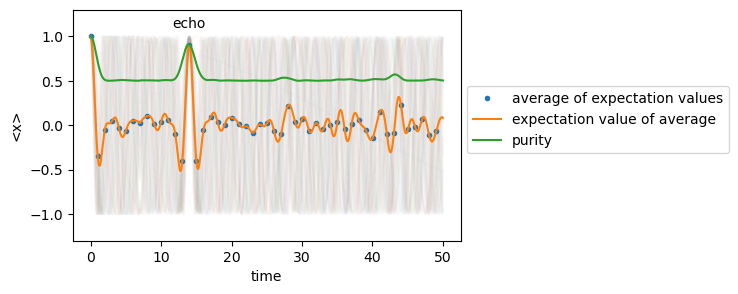

In [8]:
# import progress bar form tools
from tools import progressbar

# function to get the trajectories and the average state
def sampler(psi0, times, sample, O, d=0, t_pi=0, T2=np.inf):
    trajs = []
    rho_t = [0 * psi0 * psi0.dag() for _ in times]

    # choose a short pulse width covering a few time steps
    dt = float(times[1] - times[0])
    tau = max(3 * dt, 1e-9)            # pulse duration
    A = np.pi / (2 * tau)              # amplitude so that ∫ f(t) dt = π/2

    # time-dependent control for a π-pulse at t_pi
    def f(t, args):
        t_pi = args["t_pi"]; tau = args["tau"]; A = args["A"]
        return A if abs(t - t_pi) <= tau / 2 else 0.0

    td_args = {"t_pi": t_pi, "tau": tau, "A": A}

    for jj in progressbar(range(sample)):
        H = (B0 + np.random.normal(0, d)) * sz / 2

        c_ops = []
        if T2 != np.inf:
            c_ops = [np.sqrt(1/T2) * sx, np.sqrt(1/T2) * sy, np.sqrt(1/T2) * sz]

        # time-dependent Hamiltonian: H(t) = H + f(t) * sx
        result = qt.mesolve([H, [sx, f]], psi0, times, c_ops, [], args=td_args)

        states = result.states
        Os = [qt.expect(O, state) for state in states]
        trajs.append(Os)
        for i, state in enumerate(states):
            rho_t[i] += state
    return trajs, [r / sample for r in rho_t]

# downsample function to look only at a subset of points
def DS(x, N = 10):
    return x[::int(np.ceil( len(x) / N ))]

# random seed
np.random.seed(0)
    
# number of spins
sample = 50

# field strength
B0 = 2

# field standard deviation
d = 0.8

# pulse time
t_pi = 7

# pauli operators
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

# operator to measure
O = sx

# initial state
psi0 = qt.ket2dm(qt.basis(2,0) + qt.basis(2,1)).unit()

# final time
tf = 50

# time domain
times = np.linspace(0,tf,1000)

# trajectories and average state
trajs, rho_t = sampler(psi0,times,sample,O,d=d,t_pi=t_pi)
        
# ----- plot ------
fig, ax = plt.subplots(figsize = (5,3))
# plot independent trajectories
for xs in trajs:
    ax.plot(times, xs, alpha = 1/sample);
# plot average of trajectories
ax.plot(DS(times,50), DS(np.mean(trajs, axis=0),50),  '.', label = 'average of expectation values')
# plot expectation value of the average state (proper mixture)
ax.plot(times, np.array([qt.expect(O, state) for state in rho_t]), label = 'expectation value of average')
# plot purity of the proper mixture
ax.plot(times, np.array([state.purity() for state in rho_t]), label = 'purity')
ax.set_xlabel('time');
ax.set_ylabel('<x>');
ax.annotate('echo',(2*t_pi,1.1),ha='center')
ax.legend(bbox_to_anchor=(1., 0.7));
ax.set_ylim([-1.3,1.3]);

## Proper Mixture: Spin echo with decoherence

Repeat the above calculations consider an additional decoherence process given by the isotropic depolaristion noise generate by the Lindblad operators $\sigma_x,\sigma_y,\sigma_z$ at a rate $\gamma = 1/T_2$, using $T_2 = 200$.

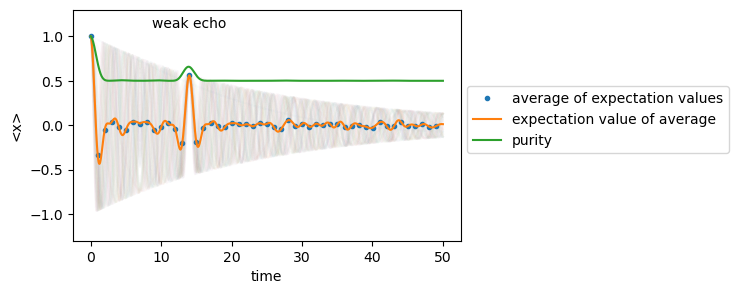

In [9]:
# random seed
np.random.seed(0)

# decoherence time
T2 = 100

# trajectories and average state
trajs, rho_t = sampler(psi0,times,sample,O,d=d,t_pi=t_pi,T2=T2)
        
# ----- plot ------
fig, ax = plt.subplots(figsize = (5,3))
# plot independent trajectories
for xs in trajs:
    ax.plot(times, xs, alpha = 1/sample);
# plot average of trajectories
ax.plot(DS(times,50), DS(np.mean(trajs, axis=0),50),  '.', label = 'average of expectation values')
# plot expectation value of the average state (proper mixture)
ax.plot(times, np.array([qt.expect(O, state) for state in rho_t]), label = 'expectation value of average')
# plot purity of the proper mixture
ax.plot(times, np.array([state.purity() for state in rho_t]), label = 'purity')
ax.set_xlabel('time');
ax.set_ylabel('<x>');
ax.annotate('weak echo',(2*t_pi,1.1),ha='center')
ax.legend(bbox_to_anchor=(1., 0.7));
ax.set_ylim([-1.3,1.3]);

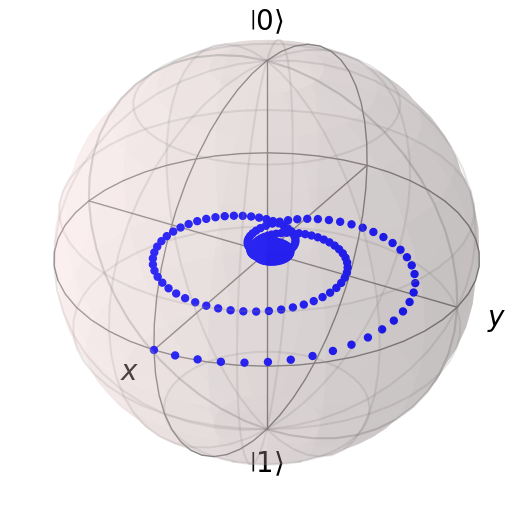

In [12]:
# get states
states_decoh = rho_t

# Bloch vectors
bloch_vectors_decoh = np.real(np.array([[qt.expect(sx, state), qt.expect(sy, state), qt.expect(sz, state)] for state in states_decoh]))

# Bloch sphere
b = qt.Bloch()
b.add_points(bloch_vectors_decoh.T)
b.show()

## Improper mixture: Interacting qubits

We now consider two initially uncorrelated qubits (product state) that evolve under the effect of some two-body interaction, such as $\sigma_x\otimes\sigma_x$, and look at the purity of the partial state of the system.

- Choose any local internal Hamiltonian $H_0 = H_0^{(1)}\otimes \mathbb{1} + \mathbb{1}\otimes H_0^{(2)}$
- Choose any interacting Hamiltonian, such as $H_1 = \sigma_x\otimes\sigma_y$, such that $[H_0,H_1]\neq 0$
- Choose any initial product state $|\psi_0\rangle = |\psi_0^{(1)}\rangle\otimes|\psi_0^{(2)}\rangle $
- Evolve the system and measure some observable $O(t)= \mathrm{Tr}[O\rho(t)]$ as a function of time
- Calculate the purity of a partial state as a function of time $\mathcal{P}[\mathrm{Tr}_2\rho(t)]$

Then, calculate the *[negativity](https://en.wikipedia.org/wiki/Negativity_(quantum_mechanics))* (an entanglement measure) $\mathcal{N}[\rho(t)]$ as a function of time, where:

$\mathcal{N}[\rho] := \frac{1}{2}(||\rho^{T_1}||_1-1)$, where
-  $||X||_1 = \text{Tr}|X| = \text{Tr} \sqrt{X^\dagger X}$
-  $\rho^{T_1}$ is the partial transpose with respect to system 1.

**Note**: $\mathcal{N}=0$ for separable states, $\mathcal{N}>0$ for entangled states, $\mathcal{N}=0.5$ for maximally entangled 2-qubit states.

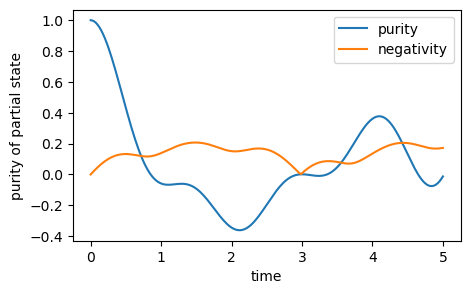

In [10]:
# internal Hamiltonian (local)
H0 = qt.tensor(sz, qt.qeye(2)) + qt.tensor(qt.qeye(2), sz)

# interaction (two-body interaction)
H1 = qt.tensor(sx, sx)

# total Hamiltonian
H = H0 + H1

# local initial states
# subsystem A
psiA = (qt.basis(2,0) + 1j * qt.basis(2,1)).unit()

# subsystem A density operator
rhoA = psiA * psiA.dag()

# subsystem B density operator
rhoB = rhoA

# initial product state
rho0 = qt.tensor(rhoA, rhoB)

# ----- dynamics ------

t0,tf = 0,5                      # initial, final time
steps = 200                      # timesteps
times = np.linspace(t0,tf,steps) # time span
O = H0                           # observable to monitor

# solve
result = qt.sesolve(H, rho0, times, [])

states = result.states

# measure the purity
purity = np.array([qt.ptrace(state, 0).purity() for state in states])

# measure the negativity
negativity = np.array([qt.negativity(state, 0) for state in states])

# ----- plot ------
fig, ax = plt.subplots(figsize = (5,3))
ax.plot(times, purity, label = 'purity');
ax.plot(times, negativity, label = 'negativity');
ax.set_xlabel('time');
ax.set_ylabel('purity of partial state');
ax.legend();

### Bloch sphere representation

Any qubit density operator $\rho$ can be represented as a vector in a real 3D vector space $\vec{r} = (r_x,r_y,r_z)$ as:

$\rho =  \frac{\mathbb{1}+\vec{r}\cdot\vec{\sigma}}{2}$,

where $\vec{\sigma} = (\sigma_x,\sigma_y,\sigma_z)$ is a symbolic vector of Pauli operators. This is called the [Bloch representation](https://en.wikipedia.org/wiki/Bloch_sphere). The vector $\lVert\vec{r}\rVert \leq 1$ belongs to a ball of radius 1 called the Bloch ball, whose surface (the Bloch sphere) contains only pure states and whose interior contains only mixed states.

- Calculate the expectation value of all three Pauli operators $\sigma_x,\sigma_y,\sigma_z$
- Group the expecation values into the Bloch vector $\vec{r} = (r_x,r_y,r_z)$, with $r_k = \langle\sigma_k\rangle$.
- Represent the state on the Bloch-sphere (use `plt_sphere` from the `tools` library)

Represent the dynamics of one of the qubits on the Bloch sphere.

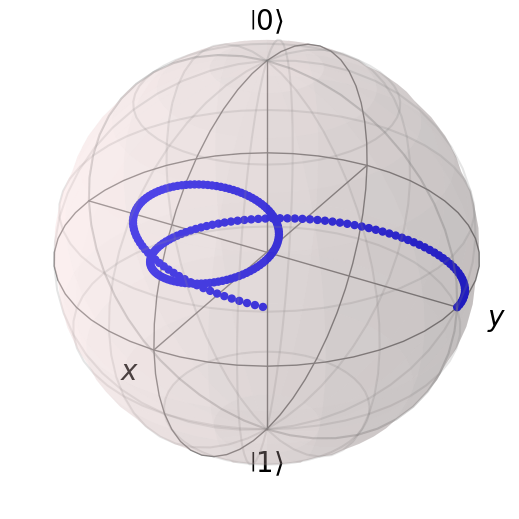

In [11]:
# Bloch sphere representation
b = qt.Bloch()

# get bloch vectors
rs = np.array([qt.expect([sx, sy, sz], qt.ptrace(state, 0)) for state in states])

b.add_points(rs.T)
b.show()